In [60]:
import numpy
from matplotlib import pyplot
import py_monte_carlo
import scipy.sparse
import scipy.linalg

In [61]:
def make_ham_and_spin(nvars, edges, transverse):
    ham = numpy.zeros((2**nvars,2**nvars))
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        h = 0.0
        for (vara, varb), j in edges:
            if state[vara] == state[varb]:
                h += j
            else:
                h -= j

        ham[i,i] += h
        for j in range(i+1, 2**nvars):
            b_state = [(j >> k) & 1 for k in range(nvars)]
            diffstate = [a^b for a,b in zip(state, b_state)]
            if sum(diffstate) != 1:
                continue
            for vark,s in enumerate(diffstate):
                if not s:
                    continue
                ham[i, j] = ham[i,j] + transverse
                ham[j, i] = ham[j,i] + transverse

    spin_diag = []
    for i in range(2**nvars):
        state = [(i >> j) & 1 for j in range(nvars)]
        spin_diag.append(numpy.sum(numpy.asarray(state)*2 - 1)**2)
    spin_op = numpy.diag(spin_diag)
    return ham, spin_op

ham, spin_op = make_ham_and_spin(nvars, edges, transverse)

In [62]:
edges = {}

rungs = 4
f = lambda m: m % (rungs*2)
for i in range(rungs):
    j = 2*i
    edges[(j,j+1)] = 1.0
    edges[(j,f(j+2))] = 1.0
    edges[(j+1,f(j+3))] = -1.0
edges =  [(k,edges[k]) for k in edges]

In [63]:
transverse = 1.0
nvars = max(v for (vs,_) in edges for v in vs)+1
beta = 1.0

In [64]:
hs = 10**numpy.linspace(-1,1,10)

In [65]:
lattice_ed_data_hs = []
lattice_ed_energy_hs = []

for h in hs:
    ham, spin_op = make_ham_and_spin(nvars, edges, h)
    expm = scipy.linalg.expm(-beta*ham)
    lattice_ed_data_hs.append(numpy.trace(spin_op @ expm) / numpy.trace(expm))
    lattice_ed_energy_hs.append(numpy.trace(ham @ expm) / numpy.trace(expm))

In [66]:
lattice_qmc_data_hs = numpy.zeros(len(hs))
lattice_qmc_energy_hs = numpy.zeros(len(hs))
graph = py_monte_carlo.Lattice(nvars, edges)

for i, h in enumerate(hs):
    graph.set_transverse_field(h)
    results = graph.run_quantum_monte_carlo_and_measure_spins(beta, 100000, 8, exponent=2)
    results, energies = zip(*results)
    lattice_qmc_data_hs[i] = numpy.mean(results, axis=0)
    lattice_qmc_energy_hs[i] = numpy.mean(energies)

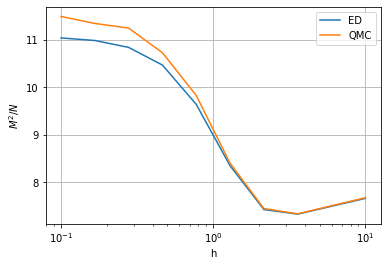

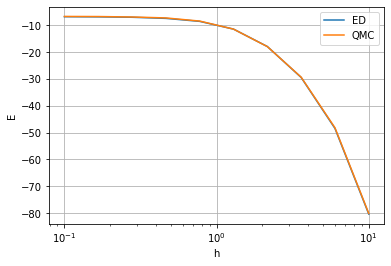

In [67]:
pyplot.plot(hs, lattice_ed_data_hs, label='ED')
pyplot.plot(hs, lattice_qmc_data_hs, label='QMC')
pyplot.xscale("log")
pyplot.legend()
pyplot.grid()
pyplot.xlabel("h")
pyplot.ylabel("$M^2/N$")
pyplot.show()

pyplot.plot(hs, lattice_ed_energy_hs, label='ED')
pyplot.plot(hs, lattice_qmc_energy_hs, label='QMC')
pyplot.xscale("log")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("h")
pyplot.ylabel("E")
pyplot.show()